<a href="https://colab.research.google.com/github/petukhovka/-algorithms_2021/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%92%D0%B5%D0%B1%D0%B8%D0%BD%D0%B0%D1%80_5_%D0%BD%D0%BE%D1%8F%D0%B1%D1%80%D1%8F_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_Tg_%D0%B1%D0%BE%D1%82%D0%B0%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Телеграм-бот на Aiogram

**Aiogram** — это асинхронная библиотека на языке Python, предназначенная для создания телеграм-ботов.

Версия Aiogram 3 предоставляет более гибкие и мощные возможности для разработки телеграм-ботов, делая этот процесс проще и эффективнее.


## Получение токена от BotFather в Telegram для нового бота:

1. **Откройте Telegram**:
   Запустите приложение Telegram на своем устройстве.

2. **Найдите BotFather**:
   В строке поиска введите "BotFather" и выберите официальный аккаунт (он должен иметь галочку верификации).

3. **Начните чат**:
   Нажмите на кнопку "Начать" или введите команду `/start` в чате с BotFather.

4. **Создайте нового бота**:
   Введите команду `/newbot`. BotFather спросит вас о названии нового бота.

5. **Укажите имя бота**:
   Напишите любое имя для вашего бота. Это имя будет отображаться пользователям. Они найдут бота по имени пользователя. Желательно дать боту понятное имя, содержащее пробелы (например, "AI Neuro Consultant").

6. **Выберите юзернейм**:
   Затем BotFather попросит вас ввести юзернейм для бота. В нем не должно быть пробелов. Он должен содержать от 5 до 32 символов и может включать латиницу, цифры или символы подчеркивания. Юзернейм должен заканчиваться на "bot" (например, "ai_neuro_consultant_bot").

7. **Получите токен**:
   После успешного создания бота, BotFather отправит вам сообщение с токеном доступа. Он будет выглядеть как длинная строка символов.

8. **Сохраните токен**:
   Сохраните токен в безопасном месте, так как он будет необходим для работы с API Telegram.

Теперь у вас есть токен, и вы можете использовать его для настройки и управления своим ботом!


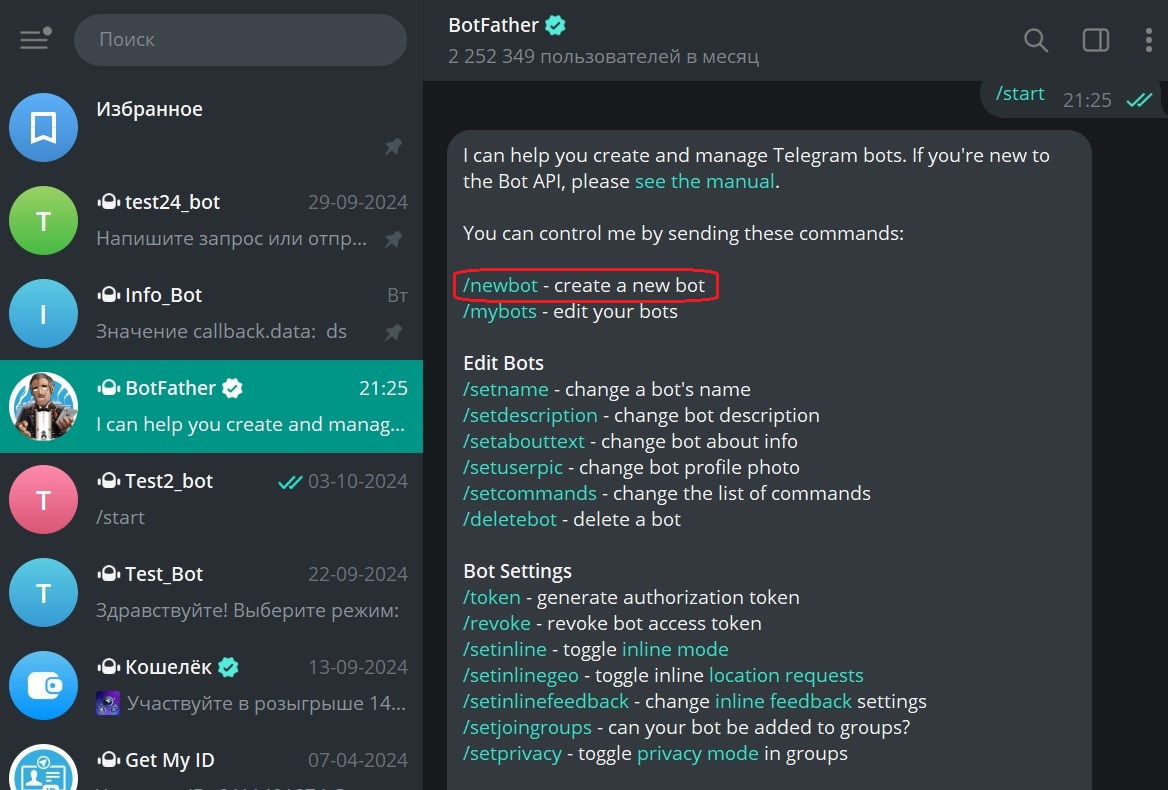



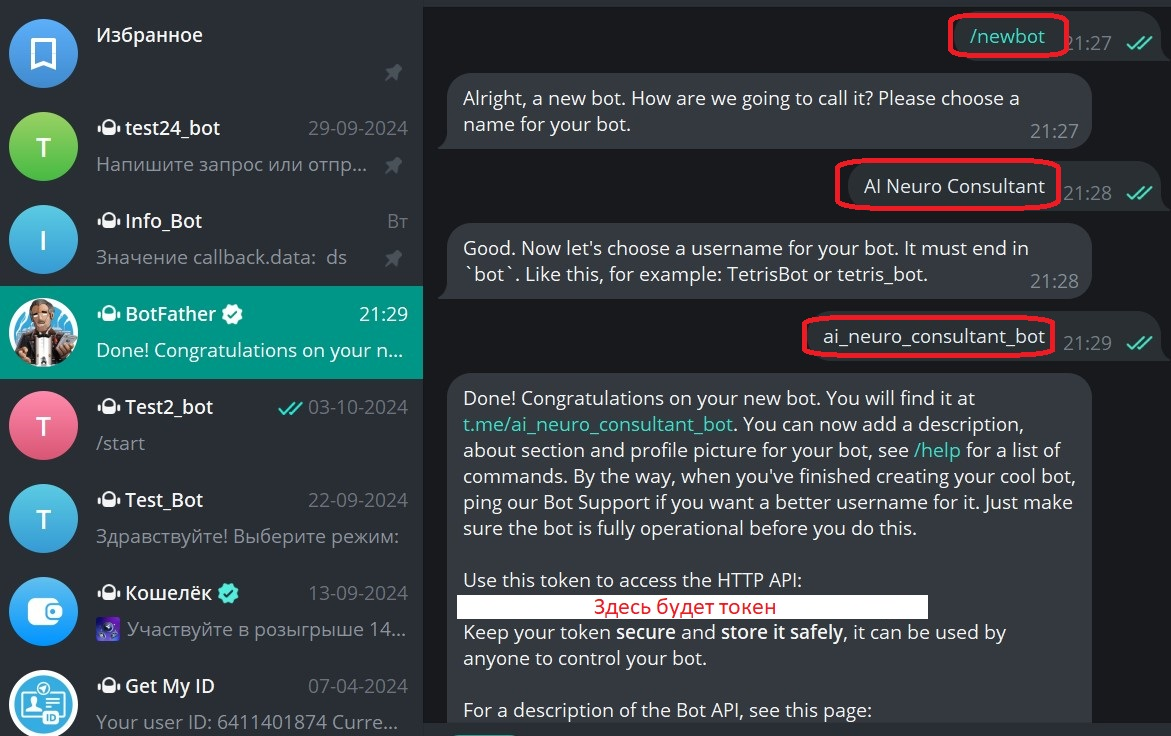

# Создаем Телеграм-бота

In [ ]:
#@title Загрузка и установка библиотек
!pip install -q aiogram==3.13.1
!pip install openai-whisper soundfile

from aiogram.client.default import DefaultBotProperties  # Импорт свойств для настройки бота по умолчанию
from aiogram.enums import ParseMode  # Импорт перечисления режимов парсинга для форматирования сообщений
import logging  # Импорт модуля логирования для отслеживания действий и ошибок в коде
import asyncio  # Импорт asyncio для работы с асинхронными задачами и событиями
from aiogram import Bot, Dispatcher  # Импорт классов бота и диспетчера для работы с Telegram Bot API
from aiogram.types import Message, CallbackQuery, Voice, Document, BotCommand, FSInputFile
from aiogram.types import ReplyKeyboardMarkup, KeyboardButton
from aiogram.types import InlineKeyboardMarkup, InlineKeyboardButton
from aiogram.utils.keyboard import ReplyKeyboardBuilder, InlineKeyboardBuilder
from aiogram.filters import Command  # Импорт фильтра для обработки текстовых команд, таких как /start и /help
from aiogram import F  # Импорт F - для работы с фильтрацией данных сообщений
from google.colab import userdata
import os  # Импорт модуля os для работы с файловой системой и переменными окружения
from aiogram import types
from PIL import Image
import whisper
from aiogram import types
# Импортируем класс KeyboardButton с псевдонимом KB для создания кнопок Reply-клавиатуры
from aiogram.types import KeyboardButton as KB
# Импортируем класс InlineKeyboardButton с псевдонимом IKB для создания кнопок Inline-клавиатуры
from aiogram.types import InlineKeyboardButton as IKB

# Инициализируем модель Whisper
model = whisper.load_model("small")  # Можно выбрать разные модели: tiny, base, small, medium, large


# Активируем поддержку асинхронных циклов (только для Colab)
# Google Colab не поддерживает обычный асинхронный цикл напрямую, из-за чего используется nest_asyncio
import nest_asyncio
nest_asyncio.apply()


# Синхронная функция send_message, которая создаёт асинхронную задачу
async def send_message(message: types.Message, response_text: str):
    # Создаем асинхронную задачу для вызова message.answer в event loop
    await message.answer(response_text)


# Функция для установки основных команд меню
async def setup_main_menu(bot: Bot, commands):
    # Создаем команды для главного меню
    main_menu_commands = [BotCommand(command=cmd, description=desc) for cmd, desc in commands]

    # Устанавливаем команды в главное меню бота
    await bot.set_my_commands(main_menu_commands)

# Функция для загрузки фотографии и сохранения в локальном хранилище
async def foto_down(message: Message):
    # Выбираем фото в наивысшем разрешении
    photo = message.photo[-1]

    # Генерируем уникальные имена файлов
    file_path = f"{photo.file_unique_id}.jpg"
    gray_file_path = f"{photo.file_unique_id}_gray.jpg"

    # Сохраняем файл с уникальным именем
    await bot.download(photo, destination=file_path)

    return file_path, gray_file_path

# Функция для отправки черно-белого фото пользователю
async def send_message_foto(message: Message, gray_file_path: str, caption: str):
    # Создаем объект FSInputFile для отправки файла фото из локального хранилища
    photo_file = FSInputFile(gray_file_path)
    # Отправляем черно-белое фото пользователю с указанным текстом
    await message.answer_photo(photo_file, caption=caption)

# Функция для удаления фото из локального хранилища
async def del_foto(file_path: str, gray_file_path: str):
    # Удаляем оба файла асинхронно
    await asyncio.to_thread(os.remove, file_path)
    await asyncio.to_thread(os.remove, gray_file_path)

# Функция подсчёта слов в текстовом файле
def count_words_in_file(file_path):
    if not file_path.endswith('.txt'):
        return 0  # Возвращаем 0, если файл не текстовый

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()

    words = content.split()
    return len(words)

async def convert_to_grayscale(input_path, output_path):
    """Функция для преобразования изображения в оттенки серого."""
    with Image.open(input_path) as img:
        gray_img = img.convert("L")  # Преобразуем в оттенки серого.
        gray_img.save(output_path)

# Функция для загрузки голосового сообщения и сохранения в локальном хранилище
async def audio_down(message: Voice):
    # Получаем объект из сообщения
    voice = message.voice

    # Генерируем уникальное имя файла
    file_path = f"{voice.file_unique_id}.ogg"

    # Скачиваем и сохраняем файл
    await bot.download(voice, destination=file_path)

    return file_path

# Функция для конвертации файла и распознавания текста
async def transcribe_text(file_path: str):
    # Конвертируем файл в формат, подходящий для Whisper (например, в .wav)
    wav_path = f"{file_path[:-4]}.wav"  # Заменяем расширение на .wav
    os.system(f"ffmpeg -i {file_path} -ac 1 -ar 16000 {wav_path}")

    # Распознаем текст через модель Whisper
    result = model.transcribe(wav_path)
    recognized_text = result["text"]

    return recognized_text

# Функция для отправки голосового сообщения обратно пользователю
async def send_voice_back(message, text: str):
    await message.answer_voice(message.voice.file_id, caption=text)

# Функция для загрузки документа и сохранения его в локальном хранилище
async def download_document(message: Message):
    document = message.document  # Получаем объект документа
    file_name = document.file_name  # Сохраняем имя файла для удобства

    # Сохраняем файл документа
    await bot.download(document, destination=file_name)

    return file_name

# Функция для отправки документа обратно пользователю
async def send_document_back(message: Message, caption: str):
    await message.answer_voice(message.document.file_id, caption=caption)

# Функция для отправки сообщения с выбранной опцией
async def option_callback(callback: types.CallbackQuery, text: str):
    await callback.message.answer(text)

async def del_file(file_path: str):
    # Удаляем файла асинхронно
    await asyncio.to_thread(os.remove, file_path)

# Функция создания Reply-клавиатуры
async def reply_keyboard(buttons_list, resize_keyboard=True, one_time_keyboard=True, input_field_placeholder="Выберите модель LLM"):
    # Создаем клавиатуру из переданного списка кнопок
    kb = [[KB(text=button) for button in row] for row in buttons_list]

    return ReplyKeyboardMarkup(
        keyboard=kb,  # Передаем созданные кнопки в параметр keyboard
        resize_keyboard=resize_keyboard,  # Параметр для подстраивания под размер экрана
        one_time_keyboard=one_time_keyboard,  # Параметр для исчезновения клавиатуры после выбора
        input_field_placeholder=input_field_placeholder  # Подсказка для поля ввода
    )

# Функция создания Inline-клавиатуры
async def inline_keyboard(buttons_list):
    # Создаем клавиатуру из переданного списка кнопок
    kb = [[IKB(text=text, callback_data=callback_data) if isinstance(callback_data, str)
           else IKB(text=text, url=callback_data) for text, callback_data in row]
          for row in buttons_list]

    return InlineKeyboardMarkup(inline_keyboard=kb)


# Функция для отправки сообщения с клавиатурой
async def send_message_keyboard(message, text: str, reply_markup):
    await message.answer(text, reply_markup=reply_markup)


# Функция для удаления Inline-клавиатуры из сообщения
async def remove_inline_keyboard(callback: types.CallbackQuery):
    await callback.message.edit_reply_markup(reply_markup=None)



async def main():
    try:
        print("Запуск бота...")
        await dp.start_polling(bot)  # Запускаем процесс polling для получения и обработки обновлений от Telegram
    finally:
        print("Остановка бота...")
        await bot.session.close()  # Закрываем сессию бота для корректного завершения работы и освобождения ресурсов

def run_bot():
  asyncio.run(main())



# Токен из секретов Colab
TELEGRAM_TOKEN = userdata.get("TELEGRAM_TOKEN")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.7/588.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.6 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=3b50798415ae443d03ad831839a52e3ef2e2a1dee6803d287be952ea53a627d5
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


100%|███████████████████████████████████████| 461M/461M [00:19<00:00, 25.2MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

## Инициализация бота и диспетчера

In [ ]:
# Создание экземпляра бота
bot = Bot(token=TELEGRAM_TOKEN)  # Передаем токен, полученный от BotFather

# Инициализация диспетчера для управления обработчиками событий (сообщения, команды, нажатие кнопок и т.д.)
# Dispatcher используется для регистрации и управления хендлерами, обрабатывающими взаимодействия с ботом
dp = Dispatcher()

**Понятие обработчиков (хендлеров)**

- Хендлеры (от англ. handler) — это функции, которые обрабатывают входящие сообщения и события в телеграм-боте. Когда пользователь отправляет сообщение боту, это сообщение попадает в хендлер, где производится обработка: бот может отвечать на сообщения, выполнять какие-либо действия, отправлять файлы или выполнять другую логику.

- В Aiogram 3 для обработки сообщений используются декораторы, которые помогают зарегистрировать хендлеры в диспетчере. С помощью хендлеров можно обрабатывать разные типы данных, такие как текстовые сообщения, команды, фотографии, видео и другие события, например нажатие кнопок.


**Обработка хендлеров в Aiogram**

- В **Aiogram** хендлеры обрабатываются **последовательно**, в том порядке, в котором они зарегистрированы в коде. Это означает, что когда бот получает сообщение или команду, он проходит по всем зарегистрированным хендлерам и проверяет, какой из них соответствует входящему событию. Если хендлер находит совпадение, он выполняет соответствующую функцию и прекращает дальнейшую проверку.


## Настройка команд

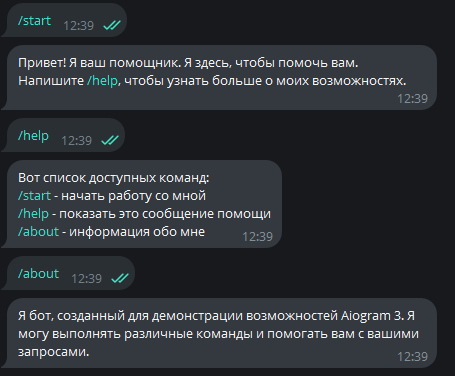

In [ ]:
# Обработчик команды /start
@dp.message(Command('start'))  # Декоратор, который регистрирует хендлер для обработки команды /start
async def cmd_start(message: Message):
    # message - объект класса Message. Содержит всю информацию о сообщении, полученном ботом: текст, отправителя, время отправки и прочее.
    # Отправляем приветственное сообщение пользователю
    await send_message(message, "Привет! Я ваш помощник. Я здесь, чтобы помочь вам. Напишите /help, чтобы узнать больше о моих возможностях.")


# Обработчик команды /help
@dp.message(Command('help'))  # Декоратор, который регистрирует хендлер для обработки команды /help
async def cmd_help(message: Message):
    # Отправляем сообщение с доступными командами и инструкциями для пользователя
    await send_message(message,"Вот список доступных команд:\n/start - начать работу со мной\n/help - показать это сообщение помощи\n/about - информация обо мне")


# Обработчик команды /about
@dp.message(Command('about'))  # Декоратор, который регистрирует хендлер для обработки команды /about
async def cmd_about(message: Message):
    # Отправляем информацию о боте, его возможностях и назначении
    await send_message(message,"Я бот, созданный для демонстрации возможностей Aiogram 3. Я могу выполнять различные команды и помогать вам с вашими запросами.")


In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Меню команд

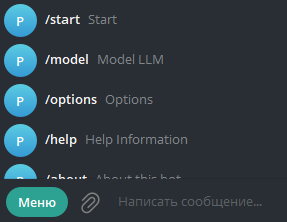

In [ ]:
@dp.startup() # Устанавливаем действия, которые будут выполнены при старте бота
async def set_menu_button(bot: Bot):
    # Определение основных команд для главного меню - кнопка (Menu) слева внизу
    commands = [
        ('/start', 'Start'), # Добавляем команду /start с описанием "Start"
        ('/model', 'Model LLM'), # Добавляем команду /model с описанием "Model"
        ('/options', 'Options'), # Добавляем команду /options с описанием "Options"
        ('/help', 'Help Information'), # Добавляем команду /help с описанием "Help Information"
        ('/about', 'About this bot') # Добавляем команду /about с описанием "About this bot"
    ]
    # Вызываем функцию для установки команд меню с передачей списка команд
    await setup_main_menu(bot, commands)

## Обработка текстовых сообщений

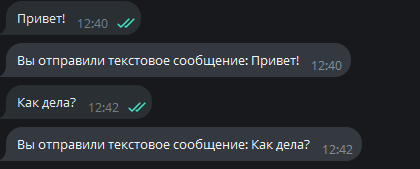

**MagicFilters (обозначается как F)** — это удобный инструмент для фильтрации сообщений и других событий. С помощью MagicFilters можно легко проверять, соответствует ли сообщение определенным критериям, и реагировать только на нужные события. Это позволяет сократить количество кода и повысить читаемость.

- Фильтр F позволяет фильтровать сообщения по типу контента, наличию текста, медиа или других параметров. Например, можно настроить хендлер так, чтобы он обрабатывал только сообщения, содержащие текст или только изображения.

In [ ]:
# Декоратор для регистрации хендлера сообщений, который будет реагировать на текстовые сообщения
# Ловим все текстовые сообщения, кроме "/model" и "/options". Используем MagicFilters - F
@dp.message(F.text & ~(F.text == "/model") & ~(F.text == "/options"))
# Определение асинхронной функции-хендлера, принимающей объект сообщения.
async def handle_text_message(message: Message):
    # Формируем ответ
    response_text = f"Вы отправили текстовое сообщение: {message.text}"
    # Отправка ответа пользователю с текстом его сообщения.
    await send_message(message, response_text)

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Обработка фото

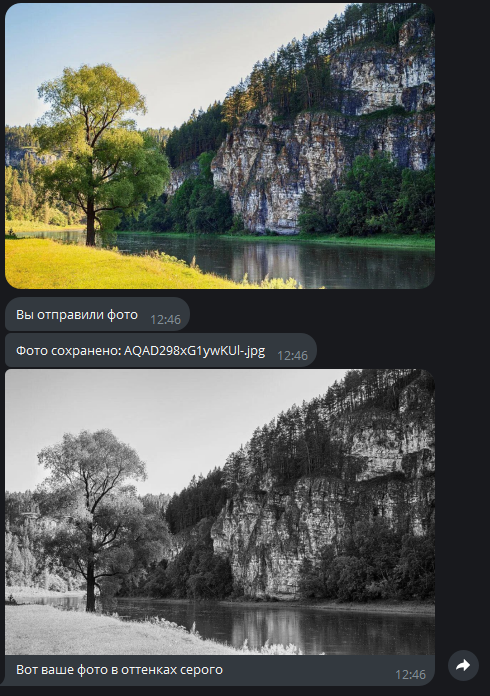

In [ ]:
@dp.message(F.photo)  # Декоратор для регистрации хендлера сообщений, который будет реагировать на фото.
async def handle_photo_message(message: Message):  # Определение асинхронной функции-хендлера, принимающей объект сообщения.

    await send_message(message,"Вы отправили фото")  # Подтверждаем получение фото.

    # Загружаем фото и получаем пути к сохранённым файлам
    file_path, gray_file_path = await foto_down(message)
    await send_message(message,f"Фото сохранено: {file_path}") # Ответное сообщение пользователю

    # Переводим изображение в оттенки серого.
    await convert_to_grayscale(file_path, gray_file_path)

    # Отправляем черно-белое фото пользователю
    await send_message_foto(message, gray_file_path, 'Вот ваше фото в оттенках серого')

    # Удаляем файлы из локального хранилища
    await del_foto(file_path, gray_file_path)

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Обработка голосового сообщения

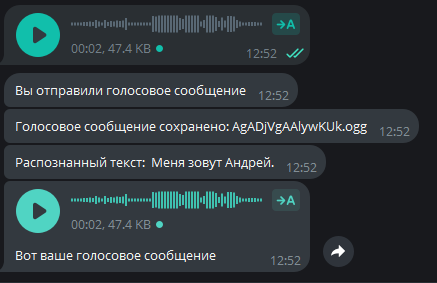

In [ ]:
@dp.message(F.voice)  # Декоратор для регистрации хендлера с голосовыми сообщениями
async def handle_voice_message(message: Voice):  # Асинхронная функция-хендлер для голосовых сообщений
    await send_message(message,'Вы отправили голосовое сообщение')  # Ответное сообщение пользователю

    # Загружаем голосовое сообщение и получаем путь к сохранённому файлу
    file_path = await audio_down(message)
    await send_message(message,f"Голосовое сообщение сохранено: {file_path}") # Ответное сообщение пользователю

    # Распознаем текст
    recognized_text = await transcribe_text(file_path)

    # Отправляем распознанный текст пользователю
    await send_message(message,f"Распознанный текст: {recognized_text}")

    # Отправляем голосовое сообщение обратно пользователю
    await send_voice_back(message, 'Вот ваше голосовое сообщение')

    # Удаляем файлы из локального хранилища
    await del_file(file_path)

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Остановка бота...


## Обработка документов в сообщении

В aiogram 3, когда вы работаете с типом сообщения document, это относится к различным типам файлов, которые пользователи могут отправлять через Telegram. В частности, в document могут попадать:
 - Файлы: Это могут быть документы в различных форматах, таких как PDF, DOCX, TXT и другие.
 - Изображения: Хотя изображения обычно отправляются как photo, они также могут быть отправлены как документы
 - Аудиофайлы: Аудиофайл может быть отправлены как документ - файл.

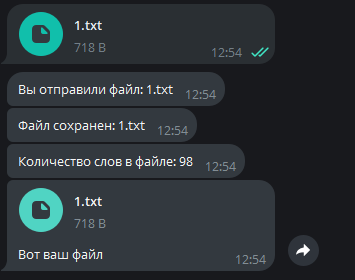

In [ ]:
@dp.message(F.document)
async def handle_document_message(message: Message):
    file_name = await download_document(message)  # Загружаем документ и получаем имя файла

    await send_message(message,f"Вы отправили файл: {file_name}") # Ответное сообщение пользователю
    await send_message(message,f"Файл сохранен: {file_name}") # Ответное сообщение пользователю

    # Подсчёт количества слов в файле
    word_count = count_words_in_file(file_name)

    # Отправляем сообщение с количеством слов, даже если оно равно нулю
    await send_message(message, f"Количество слов в файле: {word_count}")

    # Отправляем файл обратно пользователю
    await send_document_back(message, 'Вот ваш файл')

    # Удаляем файлы из локального хранилища
    await del_file(file_name)

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Reply-клавиатура


**Reply-клавиатура** — это вид клавиатуры в Telegram, которая отображается внизу экрана пользователя и предоставляет ему готовые варианты ответов или действий. Reply-клавиатура заменяет обычную клавиатуру и остается видимой до тех пор, пока пользователь не выберет опцию или клавиатура не будет скрыта.

Нажатие на Reply-кнопку инициирует отправку текста, который был на кнопке, в виде обычного текстового сообщения от пользователя боту.



Reply клавиатура (команда /model, можно выбрать в меню команд)

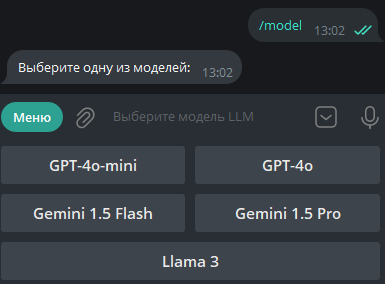

Нажатие кнопки на Reply клавиатуре обрабатывается как текстовое сообщение, где текст - это название кнопки. Результат нажатия на кнопку GPT-4o-mini

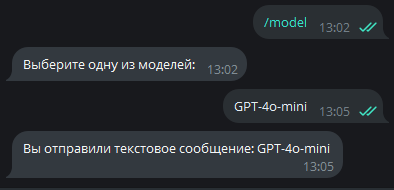

In [ ]:
# Обработчик команды /model
@dp.message(Command('model')) # Декоратор, который регистрирует хендлер для обработки команды /model
async def handle_start_command(message: Message):
    # Список с кнопками для клавиатуры
    buttons = [
        ["GPT-4o-mini", "GPT-4o"],  # Кнопки для первой строки
        ["Gemini 1.5 Flash", "Gemini 1.5 Pro"],  # Кнопки для второй строки
        ["Llama 3"]  # Кнопка для третьей строки
    ]
    # Создаем клавиатуру
    reply_markup = await reply_keyboard(buttons, # Передаем созданные кнопки
                                        resize_keyboard=True, # Клавиатура будет подстраиваться под размер экрана
                                        one_time_keyboard=True,  # Клавиатура исчезнет после выбора варианта
                                        input_field_placeholder="Выберите модель LLM")  # Подсказка для поля ввода


    # Отправляем сообщение пользователю и открываем Reply-клавиатуру
    await send_message_keyboard(message, "Выберите одну из опций:", reply_markup)

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Inline-клавиатура



**Inline-клавиатура** — это вид клавиатуры в Telegram, которая отображается непосредственно под сообщением и позволяет пользователям взаимодействовать с ботом, нажимая на кнопки.

**Основные отличия от Reply-клавиатуры:**

- Inline-клавиатура привязывается к конкретному сообщению, а не заменяет стандартную клавиатуру пользователя.

- Кнопки Inline-клавиатуры могут выполнять действия, такие как открытие веб-ссылок, отправка callback-запросов боту, что делает их более гибкими.



**Основные варианты Inline-кнопок**
- Callback-кнопка — отправляет боту callback_data, значение которого определено в коде
- URL-кнопка — открывает указанную ссылку.

Inline клавиатура (команда /options, можно выбрать в меню команд)

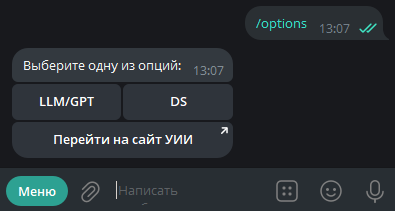


Результат нажатия на кнопку DS


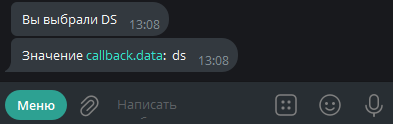

In [ ]:
# Хендлер команды /options
@dp.message(Command('options'))
async def handle_options_command(message: Message):
    # Список с кнопками для клавиатуры
    buttons = [
        [("LLM/GPT", "llm"), ("DS", "ds")],  # Первая строка кнопок с callback_data
        [("Перейти на сайт УИИ", "https://neural-university.ru/")]  # Кнопка с переходом по URL
    ]
    # Создаем клавиатуру
    reply_markup = await inline_keyboard(buttons)

    # Отправляем сообщение с Inline-клавиатурой
    await send_message_keyboard(message, "Выберите одну из опций:", reply_markup)


# Хендлер callback-запросов
@dp.callback_query(F.data)
async def handle_callback(callback: CallbackQuery):
    if callback.data == 'llm':
        await option_callback(callback, "Вы выбрали LLM/GPT")
    elif callback.data == 'ds':
        await option_callback(callback, "Вы выбрали DS")

    await option_callback(callback, f"Значение callback.data:  {callback.data}")
    # Убираем Inline-клавиатуру из сообщения
    await remove_inline_keyboard(callback)
    await callback.answer() # Ответ на callback для предотвращения зависания интерфейса

In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...


## Ответы на вопросы с помощью GPT

In [ ]:
#@title Загрузка дополнительных библиотек для работы с ботами, использующими ChatGPT

!pip install openai==0.28.1

import openai
from getpass import getpass

# Токен из секретов Colab
openai_key = userdata.get("OPENAI_API_KEY")
openai.api_key = openai_key


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2


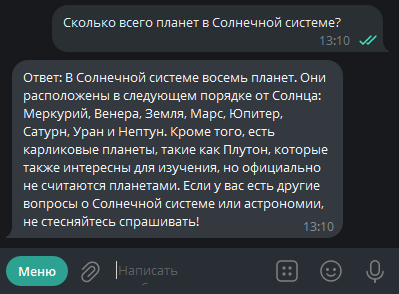

In [ ]:
# Инициализация диспетчера для управления обработчиками событий (сообщения, команды, нажатие кнопок и т.д.)
dp = Dispatcher()

# Функция для генерации ответа с использованием GPT
async def generate_answer(query):
    # Определяем системное сообщение, которое задает роль и стиль общения модели
    system_message = {
        "role": "system",
        "content": "Ты приятный собеседник, разговаривай с пользователем вежливо на любые темы"
    }

    # Создаем список сообщений, включая системное сообщение и запрос пользователя
    messages = [system_message, {"role": "user", "content": query}]

    # Вызываем API OpenAI для генерации ответа на основе переданных сообщений
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",  # Указываем модель для генерации ответа
        messages=messages,     # Передаем список сообщений
        temperature=0.5,      # Устанавливаем параметр температуры для контроля креативности (0 - детерминированный ответ, 1 - более креативный)
        max_tokens=1000       # Указываем максимальное количество токенов в ответе
    )

    # Возвращаем текст ответа от модели
    return response['choices'][0]['message']['content']


@dp.message(F.text)
# Определение асинхронной функции-хендлера, принимающей объект сообщения.
async def handle_text_message(message: Message):
    answer_gpt = await generate_answer(message.text)
    # Отправка ответа пользователю с текстом сообщения.
    await send_message(message, f"Ответ: {answer_gpt}")


In [ ]:
# Запуска бота
run_bot()

Запуск бота...


Остановка бота...
